Imports

In [ ]:
# Import modules
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, LSTM, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error
import statistics

Dataset

In [ ]:
# read data
dt = pd.read_csv('AirQuality.csv', delimiter = ';', decimal = ',')

# Get date_time columns
dt['Date_'] = pd.to_datetime(dt['Date'])
dt['Date_time'] = dt['Date_'].dt.strftime('%d/%m/%Y')
dt['Date_'] = pd.to_datetime(dt['Date_time'])

# Get required rows
dt_comp = dt[6:342]

Data Preprocessing

In [ ]:
dt_co = dt_comp[['Date_', 'Time', 'CO(GT)']]
dt_co.reset_index(inplace = True)

In [ ]:
# Imputing missing values with average of previous and next value for CO
def replace_anomalies(data):
    for i in range(len(data)):
        if data.iloc[i]['CO(GT)'] == -200:
            value_replace = (data.iloc[i-1]['CO(GT)'] + data.iloc[i+1]['CO(GT)'])/2
            data.loc[i, 'CO(GT)'] = value_replace
    return data

In [ ]:
# Preprocessing for date and time columns
def generate_hour_date(data):
    for i in range(len(data)):
        hour_ = int(data['Time'][i][:2])
        dum_replace = data.loc[i, 'Date_'].replace(hour = hour_)
        data.loc[i, 'Date_'] = dum_replace
    return data

In [ ]:
dt_co_2 = replace_anomalies(dt_co)
dt_clean = generate_hour_date(dt_co_2)

In [ ]:
# Get required columns
dt_clean_pr = dt_clean[['Date_', 'CO(GT)']]

In [ ]:
# Create time series data
dt_ts = pd.Series(dt_clean_pr['CO(GT)'].values, index = dt_clean_pr['Date_'])

# Reshape input df
dt_ts_reshape = pd.Series(dt_ts.values.reshape(-1,))

Model to predict Carbon Monoxide

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
def data_sequences(ts_values):
    X_t, y_t = split_sequence(ts_values, n_steps)
    return X_t, y_t

In [ ]:
# train --> 6 days
# val --> 1 day
# forecast --> 1 day

In [ ]:
def train_test_sequences(X_t, y_t):
    X_t_train, y_t_train = X_t[:144-n_steps], y_t[:144-n_steps]
    X_t_val, y_t_val = X_t[144-n_steps:], y_t[144-n_steps:]
    return X_t_train, y_t_train, X_t_val, y_t_val

In [ ]:
# define model
def TS_model(units_):
    
    model = Sequential()  
    model.add(LSTM(units=units_, input_shape=(n_steps, 1), activation = 'relu'))  
    model.add(Dropout(0.2))
    
#     model.add(LSTM(units=units_, activation = 'relu', return_sequences = True))  
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(units=units_, activation = 'relu'))  
#     model.add(Dropout(0.2))
      
    model.add(Dense(units = 1))  
    
    model.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')
    return model

In [ ]:
# train model function
def train_model(model, batch_size_, idx):
    earlyStopping = EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('co_model_%s.hdf5'%idx, save_best_only=True, 
                           monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, 
                                       verbose=1, min_delta=1e-4, mode='min')
    
    mod_trained = model.fit(X_t_train, y_t_train, epochs = 100, validation_data = (X_t_val, y_t_val), 
              batch_size = batch_size_, verbose = 2,
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
             )
    return mod_trained

In [ ]:
# params
n_steps = 15
units = 50
batch_size = 16


# train model

start = datetime.datetime.now()

ts_model = TS_model(units)

mape_list = []
mod_list = []
pred_all = []


for day_idx in range(7):
    X_t, y_t = data_sequences(dt_ts_reshape[24*day_idx:24*(day_idx+7)].values)
    X_t_train, y_t_train, X_t_val, y_t_val = train_test_sequences(X_t, y_t)    
    
    mod_trained = train_model(ts_model, batch_size, day_idx)
    best_model = load_model('co_model_%s.hdf5'%day_idx)
    mod_list.append(best_model)
    
    X_t_test, y_t_test = data_sequences(dt_ts_reshape[24*(day_idx+7)-n_steps:24*(day_idx+8)].values)

    pred = best_model.predict(X_t_test)
    mape = mean_absolute_percentage_error(y_t_test, pred)
    
    pred_all.extend(pred)
    mape_list.append(mape)
            
    print('Forecasting for %s done, train and val set used is from %s until %s'%(dt_ts.index[24*(day_idx+7)].date(), dt_ts.index[24*(day_idx)].date(), dt_ts.index[24*(day_idx+6)].date()))
            
            
print("time needed for all process --> ", datetime.datetime.now()-start)

In [ ]:
mod_list[0].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Get list of test dates
date_list = [str(dt_ts.index[24*(day_idx+7)].date()) for day_idx in range(7)]

In [ ]:
# Combine mape for all days and find avg(mape)
mape_all = statistics.mean(mape_list)
mape_list.append(mape_all)

date_list.append('Average')

error_df = pd.DataFrame(list(zip(date_list, mape_list)),
                       columns = ['Date', 'MAPE'])

error_df

,Date,MAPE
0,2004-03-18,0.259470
1,2004-03-19,0.198947
2,2004-03-20,0.220511
3,2004-03-21,0.176077
4,2004-03-22,0.369441
5,2004-03-23,0.285708
6,2004-03-24,0.200177
7,Average,0.244333


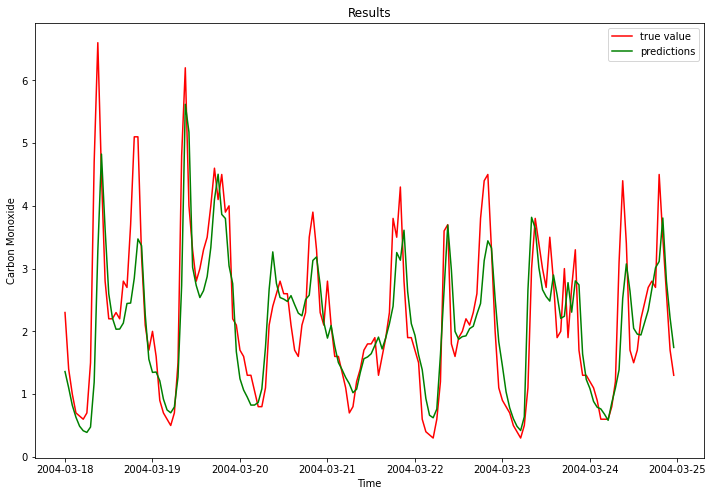

In [ ]:
# plot predictions for CO
index = dt_ts.index

plt.figure(figsize=(12,8))
plt.plot(index[168:], dt_ts[168:].values, color = 'r', label = 'true value')
plt.plot(index[168:], pred_all, color = 'g', label = 'predictions')
plt.title('Results')
plt.xlabel('Time')
plt.ylabel('Carbon Monoxide')
plt.legend()
plt.show()

In [ ]:
# Generate output file with predictions added
date_pred = [dt_ts.index[i] for i in range(168,336)]
pred_all_list = [pred_all[i][0] for i in range(len(pred_all))]

pred_dt = pd.DataFrame(list(zip(date_pred, pred_all_list)),
                      columns = ['Date', 'CO_predict'])
pred_dt.to_csv('co_pred.csv')